# Face Recognition with Local Binary Patterns (LBPs) and OpenCV

In this tutorial, you will learn how to perform face recognition using Local Binary Patterns (LBPs), OpenCV, and the cv2.face.LBPHFaceRecognizer_create function.

## The Local Binary Patterns (LBPs) for face recognition algorithm
<image src="images/what_is_face_reco_lbps_cells.png">

Then, for each of these cells, we compute a Local Binary Pattern histogram.

By definition, a histogram throws away all spatial information regarding how the patterns are oriented next to each other. However, by computing a histogram for each of the cells, we actually are able to encode a level of spatial information such as the eyes, nose, mouth, etc., that we would otherwise not have.

This spatial encoding also allows us to weigh the resulting histograms from each of the cells differently, giving more discriminative power to more distinguishing features of the face:
<image src="images/face_reco_lbps_weighting.png">

Here, we can see the original face image divided into 7×7 cells (left). Then, on the right, we can see the weighting scheme for each of the cells:

* LBP histograms for the white cells (such as the eyes) are weighed 4x more than the other cells. This simply means that we take the LBP histograms from the white cell regions and multiply them by 4 (taking into account any scaling/normalization of the histograms).
* Light gray cells (mouth and ears) contribute 2x more.
* Dark gray cells (inner cheek and forehead) only contribute 1x.
* Finally, the black cells, such as the nose and outer cheek, are totally disregarded and weighed 0x.

These weighting values were experimentally found by Ahonen et al. by running hyperparameter tuning algorithms on top of their training, validation, and testing data splits.

Finally, the weighted 7×7 LBP histograms are concatenated together to form the final feature vector.

Performing face recognition is done using the \chi^{2} distance and a nearest neighbor classifier:

* A face is presented to the system
LBPs are extracted, weighted, and concatenated in the same manner as the training data
k-NN (with k=1) is performed with the \chi^{2} distance to find the closest face in the training data.
The name of the person associated with the face with the smallest \chi^{2} distance is chosen as the final classification

Before we close this section, it’s important to note that the LBPs for face recognition algorithm has the added benefit of being updatable as new faces are introduced to the dataset.

Other popular algorithms, such as Eigenfaces, require that all faces to be identified be present at training time. This implies that if a new face is added to the dataset the entire Eigenfaces classifier has to be re-trained which can be quite computationally intensive.

Instead, the LBPs for face recognition algorithm can simply insert new face samples without having to be re-trained at all — an obvious benefit when working with face datasets where people are being added or removed from the dataset with routine frequency.



### Import Packages

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Creating our face detector

As we learned in our introduction to face recognition guide, prior to performing face recognition we need to:

1. Detect the presence of a face in an image/video stream
2. Extract the region of interest (ROI), which is the face itself

In [5]:
def detect_faces(net, image, minConfidence=0.5):
	# grab the dimensions of the image and then construct a blob
	# from it (check the netwok document to see if blob is required)
	(h, w) = image.shape[:2]
	blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
		mean=(104.0, 177.0, 123.0))

	# pass the blob through the network to obtain the face detections,
	# then initialize a list to store the predicted bounding boxes
	net.setInput(blob)
	detections = net.forward()
	boxes = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > minConfidence:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# update our bounding box results list
			boxes.append((startX, startY, endX, endY))

	# return the face detection bounding boxes
	return boxes

### Loading the CALTECH Faces dataset

The CALTECH Faces challenge is a benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions

The overall goal of this tutorial is to apply the Eigenfaces face recognition algorithm to identify each of the subjects in the CALTECH Faces dataset.

This function is responsible for:

1. Looping over all images in the CALTECH Faces dataset
2. Counting the number of example images we have for each individual
3. Throwing out any individuals who have less than N faces for training data (otherwise we would run into a class imbalance problem)
4. Applying our detect_faces function
5. Extracting each individual face ROI
6. Returning the face ROIs and class labels (i.e., names of the people) to the calling function


In [6]:
def load_face_dataset(inputPath, net, minConfidence=0.5,
	minSamples=15):
	# grab the paths to all images in our input directory, extract
	# the name of the person (i.e., class label) from the directory
	# structure, and count the number of example images we have per
	# face
	imagePaths = list(paths.list_images(inputPath))
	names = [p.split(os.path.sep)[-2] for p in imagePaths]
	(names, counts) = np.unique(names, return_counts=True)
	names = names.tolist()

	# initialize lists to store our extracted faces and associated
	# labels
	faces = []
	labels = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image from disk and extract the name of the person
		# from the subdirectory structure
		image = cv2.imread(imagePath)
		name = imagePath.split(os.path.sep)[-2]

		# only process images that have a sufficient number of
		# examples belonging to the class
		if counts[names.index(name)] < minSamples:
			continue

		# perform face detection
		boxes = detect_faces(net, image, minConfidence)

		# loop over the bounding boxes
		for (startX, startY, endX, endY) in boxes:
			# extract the face ROI, resize it, and convert it to
			# grayscale
			faceROI = image[startY:endY, startX:endX]
			faceROI = cv2.resize(faceROI, (47, 62))
			faceROI = cv2.cvtColor(faceROI, cv2.COLOR_BGR2GRAY)

			# update our faces and labels lists
			faces.append(faceROI)
			labels.append(name)

	# convert our faces and labels lists to NumPy arrays
	faces = np.array(faces)
	labels = np.array(labels)

	# return a 2-tuple of the faces and labels
	return (faces, labels)

### Implementing Local Binary Patterns for face recognition

In [7]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", type=str, required=True,
# 	help="path to input directory of images")
# ap.add_argument("-f", "--face", type=str,
# 	default="face_detector",
# 	help="path to face detector model directory")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
# 	help="minimum probability to filter weak detections")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "datasets/caltech_faces",
	"face": "pyimagesearch/face_detector",
    "confidence": 0.5,
}

In [8]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...


In [9]:
# load the CALTECH faces dataset
print("[INFO] loading dataset...")
(faces, labels) = load_face_dataset(args["input"], net,
	minConfidence=0.5, minSamples=20)
print("[INFO] {} images in dataset".format(len(faces)))

# encode the string labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# construct our training and testing split
(trainX, testX, trainY, testY) = train_test_split(faces,
	labels, test_size=0.25, stratify=labels, random_state=42)

[INFO] loading dataset...
[INFO] 397 images in dataset


The cv2.face.LBPHFaceRecognizer_create function accepts a few (optional) arguments that I explicitly define to make this example clear.

The radius=2 and neighbors=16 parameters are part of the Local Binary Patterns image descriptor. These values control the number of pixels included in the computation of the histogram, along with the radius these pixels lie on. Please see the Local Binary Patterns tutorial if you need a refresher on these parameters.

The grid_x and grid_y controls the number of MxN cells in the face recognition algorithm.

While the original paper by Ahonen et al. suggested using a 7×7 grid, I prefer using an 8×8 grid which allows for more granularity, resulting in higher accuracy.

However, this increased accuracy comes at the expense of (1) longer feature extraction/comparison times (due to the number of LBP histograms to be computed jumping from 49 to 64), and perhaps more importantly, (2) considerably more memory consumption to store the feature vectors.

In [10]:
# train our LBP face recognizer
print("[INFO] training face recognizer...")
recognizer = cv2.face.LBPHFaceRecognizer_create(
	radius=2, neighbors=16, grid_x=8, grid_y=8)
start = time.time()
recognizer.train(trainX, trainY)
end = time.time()
print("[INFO] training took {:.4f} seconds".format(end - start))

[INFO] training face recognizer...
[INFO] training took 5.1749 seconds


In [11]:
# initialize the list of predictions and confidence scores
print("[INFO] gathering predictions...")
predictions = []
confidence = []
start = time.time()

# loop over the test data
for i in range(0, len(testX)):
	# classify the face and update the list of predictions and
	# confidence scores
	(prediction, conf) = recognizer.predict(testX[i])
	predictions.append(prediction)
	confidence.append(conf)

# measure how long making predictions took
end = time.time()
print("[INFO] inference took {:.4f} seconds".format(end - start))

# show the classification report
print(classification_report(testY, predictions,
	target_names=le.classes_))

[INFO] gathering predictions...
[INFO] inference took 190.2803 seconds
              precision    recall  f1-score   support

     abraham       1.00      1.00      1.00         5
       allen       1.00      1.00      1.00         8
      carmen       1.00      1.00      1.00         5
      conrad       1.00      0.83      0.91         6
     cynthia       0.80      0.80      0.80         5
     darrell       0.83      1.00      0.91         5
       frank       1.00      1.00      1.00         5
      gloria       1.00      1.00      1.00         5
     jacques       1.00      1.00      1.00         6
        judy       1.00      1.00      1.00         5
       julie       1.00      1.00      1.00         5
     kenneth       1.00      0.83      0.91         6
         mae       1.00      1.00      1.00         5
     raymond       1.00      0.83      0.91         6
        rick       1.00      1.00      1.00         6
      sherry       0.75      1.00      0.86         6
     tiffa

[INFO] prediction: carmen, actual: carmen, confidence: 182.96


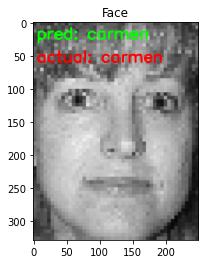

[INFO] prediction: rick, actual: rick, confidence: 171.64


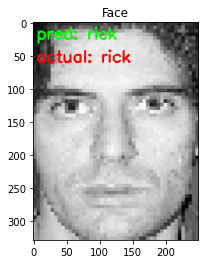

[INFO] prediction: sherry, actual: sherry, confidence: 165.44


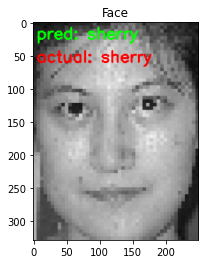

[INFO] prediction: judy, actual: judy, confidence: 172.27


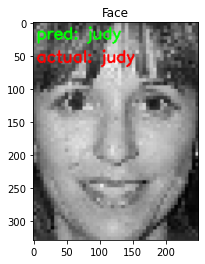

[INFO] prediction: julie, actual: julie, confidence: 156.67


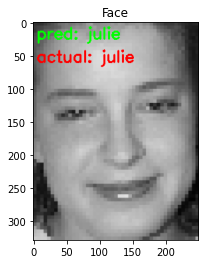

[INFO] prediction: judy, actual: judy, confidence: 174.99


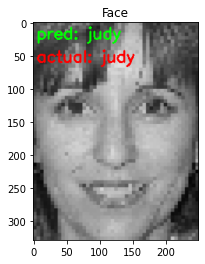

[INFO] prediction: frank, actual: frank, confidence: 169.47


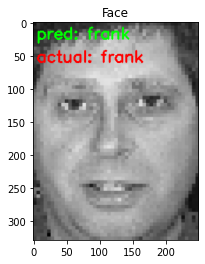

[INFO] prediction: abraham, actual: abraham, confidence: 169.48


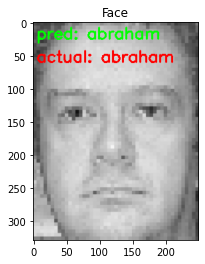

[INFO] prediction: willie, actual: willie, confidence: 172.83


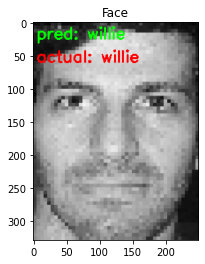

[INFO] prediction: jacques, actual: jacques, confidence: 170.23


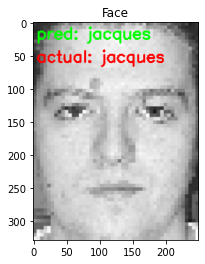

In [12]:
# generate a sample of testing data
idxs = np.random.choice(range(0, len(testY)), size=10, replace=False)

# loop over a sample of the testing data
for i in idxs:
	# grab the predicted name and actual name
	predName = le.inverse_transform([predictions[i]])[0]
	actualName = le.classes_[testY[i]]

	# grab the face image and resize it such that we can easily see
	# it on our screen
	face = np.dstack([testX[i]] * 3)
	face = imutils.resize(face, width=250)

	# draw the predicted name and actual name on the image
	cv2.putText(face, "pred: {}".format(predName), (5, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
	cv2.putText(face, "actual: {}".format(actualName), (5, 60),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

	# display the predicted name, actual name, and confidence of the
	# prediction (i.e., chi-squared distance; the *lower* the distance
	# is the *more confident* the prediction is)
	print("[INFO] prediction: {}, actual: {}, confidence: {:.2f}".format(
		predName, actualName, confidence[i]))

	# display the current face to our screen
	plt_imshow("Face", face)